Generating a dataset ...
Training ...


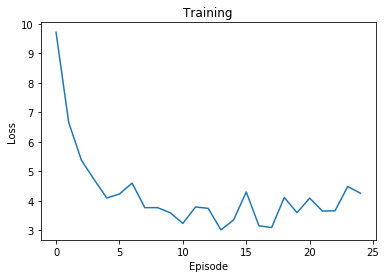

 6 33] [ 0  6  8  8 21 33 42 52 77 95] [ 0  6  8  8 21 33 42 52 77 95]
[96 12 11 75  4 51 27 51 76 35] [ 4 11 12 27 35 51 51 75 76 96] [ 4 11 12 27 35 51 51 75 76 96]
[22 95  4 67 63 55 71  8  2 71] [ 2  4  8 22 55 63 67 71 71 95] [ 2  4  8 22 55 63 63 71 71 95]
[25 65  6 71 93 50 64 45 18 50] [ 6 18 25 45 50 50 64 65 71 93] [ 6 18 25 45 50 50 64 65 71 93]
[93 65 96 78 49 24 47 38 76 82] [24 38 47 49 65 76 78 82 93 96] [24 38 47 49 65 76 78 82 93 96]
[51 60 11 28 97 38  0 40 95 93] [ 0 11 28 38 40 51 60 93 95 97] [ 0 11 28 38 40 51 60 93 93 97]
[95 26 26  2 94  5 35 53 42 49] [ 2  5 26 26 35 42 49 53 94 95] [ 2  5 26 26 35 42 49 53 94 95]
[66 84 44 85 97 82 86 21 55 35] [21 35 44 55 66 82 84 85 86 97] [21 35 44 55 66 82 84 86 97 97]
[69 35 22 48 72 80 88 11 28  7] [ 7 11 22 28 35 48 69 72 80 88] [ 7 11 22 28 35 48 69 72 80 88]
[42 71 38 57 11 55 13 89 85 15] [11 13 15 38 42 55 57 71 85 89] [11 13 15 38 42 55 57 71 85 89]
[13 64  8 80 31 76 95 57 72 16] [ 8 13 16 31 57 64 72 76 80 95] [

In [3]:
""" 
Pointer networks example
"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 32
RANGE = [0, 100]
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 50000
EPOCHS = 25


VALIDATION_RATIO = .2



def main():

    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)
    # train-validate spilit
    ds_len = len(ds)
    indexes = list(range(ds_len))
    random.shuffle(indexes) # shuffle them
    spilit_spot = int(math.floor(VALIDATION_RATIO * ds_len))
    
    train_indexes = indexes[spilit_spot:]
    validation_indexes = indexes[:spilit_spot]

    # samples 
    train_sampler = SubsetRandomSampler(train_indexes)
    validation_sampler = SubsetRandomSampler(validation_indexes)

    # loaders
    train_dataloader = DataLoader(ds,
                            sampler=train_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)

    validation_dataloader = DataLoader(ds,
                            sampler=validation_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    


    # The Pointer Network model
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0005)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            _, sequence_length = batch.shape
            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #back propagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to check how store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show(block=False)

    ################## Validation #############
    print('\n\n\nValidation ...')
    print('\ninput\ttarget\tpointer')
    pointer_network.eval()
    for batch, target_sequences in validation_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ingonre last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])

     ################## Testing #############
    print('\n\n\n Testing of higher length 15')
    ds = SortingDataset(range_=RANGE, lengths=[15], SOS_SYMBOL=SOS_SYMBOL, num_instances=100)
    test_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    for batch, target_sequences in test_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ingonre last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])


if __name__ is '__main__':
    main()
